# FULL PIPELINE


In [25]:
cnt=0
for SAMPLE_NAME in os.listdir("data"):
    if os.path.exists(os.path.join("data", SAMPLE_NAME,"electrode_locs.npy")):
        cnt+=1

In [26]:
cnt

76

This notebook will merge four steps:

1 -  segment electrodes from fluoroscopy return coordinates

2 - segment electodes from CT return coordinates

3 -  map CT to 2D

4 -  map coordinates back to 3D

In [1]:
# Import dependencies
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import os
import imageio
import circle_fit as cf
from utils import euclidean_distance_coords
from tabulate import tabulate

C:\tools\miniconda3\envs\hairme\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\tools\miniconda3\envs\hairme\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\tools\miniconda3\envs\hairme\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load patient data
SAMPLE_NAME = 'DBS_bG56'
HULL_FILE_NAME = os.path.join('data/' + SAMPLE_NAME,"hull_rh.mat")
PRECT_FILE_NAME = os.path.join('data/' + SAMPLE_NAME,"preop_ct.nii")
POSTCT_FILE_NAME = os.path.join('data/' + SAMPLE_NAME,"postop_ct.nii")
FLUORO_FILE_NAME = os.path.join('data/' + SAMPLE_NAME,"fluoro.tif")
GT_NAME = os.path.join('data/' + SAMPLE_NAME,"electrode_locs.npy")

# read .mat File
hull = scipy.io.loadmat(HULL_FILE_NAME)
points_hull=np.array(hull['mask_indices'])

#read pre op CT
prect = nib.load(PRECT_FILE_NAME)
prect_data = np.nan_to_num(np.array(prect.get_fdata()))
Tmatrix = np.transpose(prect.affine)

#read post op CT
postct = nib.load(POSTCT_FILE_NAME)
postct_data = np.nan_to_num(np.array(postct.get_fdata()))

# fourth channel is infrared
fluoro = imageio.imread(FLUORO_FILE_NAME)
#fluoro = cv2.cvtColor(fluoro, cv2.COLOR_BGR2GRAY)
ground_truth = np.load(GT_NAME) 

C:\Users\VukadinoviM\AppData\Local\Temp\ipykernel_20836\1030300452.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  fluoro = imageio.imread(FLUORO_FILE_NAME)


## STEP 1: SEGMENT FROM FLUORO

In [3]:
# Run first component script
from fluoro_segmentation import fluoro_get_coordinates
coords_dict = fluoro_get_coordinates(fluoro)

fluoro_segmentation.py successfully executed.


In [4]:
coords_dict['ecog'] = np.array(coords_dict['ecog'])

### Visual Check

RUN ONLY ONCE

In [5]:
coords_dict['pin'] = coords_dict['pin'][0].reshape(1,-1)

In [6]:
coords_dict['dbs']= np.array(coords_dict['dbs'])

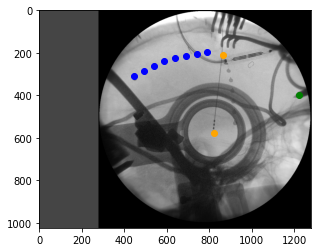

In [7]:
# Display segmented features on fluoro image
import matplotlib.pyplot as plt
plt.imshow(fluoro,cmap='gray')
plt.scatter(coords_dict['ecog'][:,0], coords_dict['ecog'][:,1],c='blue')
plt.scatter(coords_dict['dbs'][:,0], coords_dict['dbs'][:,1],c='orange')
plt.scatter(coords_dict['pin'][:,0], coords_dict['pin'][:,1],c='green')

## STEP 2: SEGMENT FROM CT

In [8]:
# Run second component script
from ct_segmentation import ct_get_landmarks
coords3d_dic = ct_get_landmarks(prect_data, postct_data)
pins_ct = coords3d_dic['pin']

1/1 [==============================] - 3s 3s/step
ct_segmentation.py successfully executed.


C:\Users\VukadinoviM\Documents\BrainReg\ct_segmentation.py:92: RuntimeWarning: invalid value encountered in divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img))


### Visual Check

In [9]:
# Display the segmented features on CT volume
from mayavi import mlab
mlab.init_notebook()
fig = mlab.figure(bgcolor=(1, 1, 1), size=(500, 500))
source_1 = mlab.pipeline.scalar_field(prect_data)
surface = mlab.pipeline.iso_surface(source_1, 
                          contours=[256,], 
                          opacity=0.5, 
                          colormap = 'black-white')

source_2 = mlab.pipeline.scalar_field(postct_data[:,:128,:])
surface = mlab.pipeline.iso_surface(source_2, 
                          contours=[256,], 
                          opacity=0.8, 
                          colormap = 'black-white')
mlab.points3d(coords3d_dic['pin'][:,0],coords3d_dic['pin'][:,1],coords3d_dic['pin'][:,2], color = (0.2,1,.2), scale_factor=10)
mlab.points3d(coords3d_dic['lead'][:,0],coords3d_dic['lead'][:,1],coords3d_dic['lead'][:,2], color = (1,0,0), scale_factor=10)

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…

## STEP 3: MAP TO 2D

When converting from pixel to 3d coordinate mayavi just centers x and y, so (1400,1200) image will have a center at (700,600) and possibly x and y switched

In [10]:
# Refine inputs to 3rd component function
fluoro2 = cv2.cvtColor(fluoro, cv2.COLOR_BGR2GRAY)
dbs = np.array([coords_dict['dbs']])
pins2d = coords_dict['pin']
pins_fl = np.vstack([pins2d, dbs.squeeze()])
coords_2d = coords_dict['ecog']
pins3d = coords3d_dic['pin']
lead_ct = coords3d_dic['lead']
pins_ct = np.concatenate((pins3d,lead_ct),axis=0)

In [11]:
fluoro.shape

(1024, 1280, 4)

In [12]:
# Run third component function
from fluoro_ct_alignment import project_to_2d
aligned_coords = project_to_2d(postct_data,fluoro2,pins_fl,pins_ct,coords_2d)

fluoro_ct_alignment.py successfully executed.


### Visual Inspect

[[ 4.71376490e+02 -6.46955593e+01]
 [ 4.34648911e+02 -4.35356845e+01]
 [ 3.97765942e+02 -2.17829247e+01]
 [ 3.27859215e+02  2.10153657e+01]
 [ 5.09436319e+02 -8.53281050e+01]
 [ 3.62291415e+02 -4.47966966e-01]
 [ 5.47293899e+02 -1.05687977e+02]
 [ 5.85380422e+02 -1.25414434e+02]]


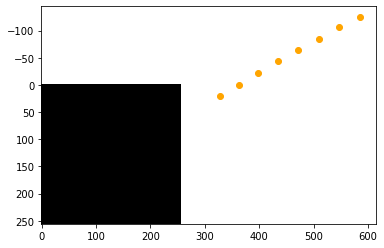

In [13]:
# Display aligned electrode coordinates on blank image space
plt.imshow(np.zeros([256,256]),cmap='gray')
plt.scatter(aligned_coords[:,0],aligned_coords[:,1],color='orange')
print(aligned_coords)

## STEP 4: MAP TO 3D

In [14]:
# Run fourth component function
from hull_projection import project_to_3d
predictions = project_to_3d(aligned_coords, points_hull, Tmatrix)
predictions = np.array(predictions)
predictions

hull_projection.py executed succesfully
[array([  10.07774717, -354.34086499,  162.34430343]), array([  10.22300361, -317.60886304,  141.20620245]), array([  10.11419454, -280.72037627,  119.47582657]), array([  10.00413322, -210.79983939,   76.72157618]), array([  10.36340835, -392.40250896,  182.95561787]), array([  10.16277659, -245.23966077,   98.16282277]), array([  10.46658796, -430.26154742,  203.29453945]), array([  10.38405999, -468.34791978,  223.00069714])]


array([[  10.07774717, -354.34086499,  162.34430343],
       [  10.22300361, -317.60886304,  141.20620245],
       [  10.11419454, -280.72037627,  119.47582657],
       [  10.00413322, -210.79983939,   76.72157618],
       [  10.36340835, -392.40250896,  182.95561787],
       [  10.16277659, -245.23966077,   98.16282277],
       [  10.46658796, -430.26154742,  203.29453945],
       [  10.38405999, -468.34791978,  223.00069714]])

### Visual Inspect

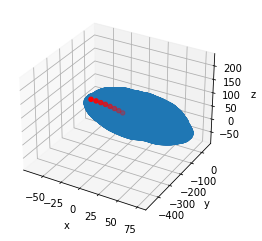

In [15]:
# Inspect the projected coordinates on the MRI hull
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(points_hull[:,0], points_hull[:,1], points_hull[:,2], cmap='green', alpha=0.2)
ax.scatter3D(predictions[:,0], predictions[:,1], predictions[:,2], c='r',)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

For a better visualization, use plotly or mayavi. Here for the sake of fast visualization we use matplotlib.

In [16]:
ground_truth

array([[ 60.54408517,   0.1997396 ,  -0.17043073],
       [ 59.54408362,  -0.80026044,   7.82957021],
       [ 59.54408206,  -2.80026051,  15.82957117],
       [ 57.54408062,  -4.80026053,  23.82957211],
       [ 55.54407939,  -6.80026055,  30.82957294],
       [ 51.54407834,  -9.80026053,  37.82957375],
       [ 48.54407759, -11.80026051,  42.82957433],
       [ 42.54407712, -15.80026043,  47.82957489],
       [ 40.54407755, -28.80026041,  49.82957514],
       [ 41.5440783 , -35.80026042,  47.82957492],
       [ 44.5440792 , -43.80026045,  44.8295746 ],
       [ 45.54408015, -50.80026044,  41.82957427],
       [ 46.54408138, -58.80026043,  37.82957381],
       [ 45.54408272, -66.80026038,  33.82957335],
       [ 48.54408392, -72.8002604 ,  28.82957279],
       [ 52.54408526, -78.80026043,  22.82957211]])

In [17]:
predictions

array([[  10.07774717, -354.34086499,  162.34430343],
       [  10.22300361, -317.60886304,  141.20620245],
       [  10.11419454, -280.72037627,  119.47582657],
       [  10.00413322, -210.79983939,   76.72157618],
       [  10.36340835, -392.40250896,  182.95561787],
       [  10.16277659, -245.23966077,   98.16282277],
       [  10.46658796, -430.26154742,  203.29453945],
       [  10.38405999, -468.34791978,  223.00069714]])

In [20]:
ground_truth= ground_truth[:8]

In [21]:
euclidean_distance_coords(predictions, ground_truth)

189.6610190514947